The mass of the star / black hole is: 1.865541785984487e+30 kgs.
The mass of the satellite is: 6e+24 kgs.


  1%|█                                                                             | 20/1461 [00:00<00:00, 2114.92it/s]

The orbiting planet has crossed the event horizon. (Angle alarm)
[0. 0. 0. ... 0. 0. 0.]
3.141592653589793


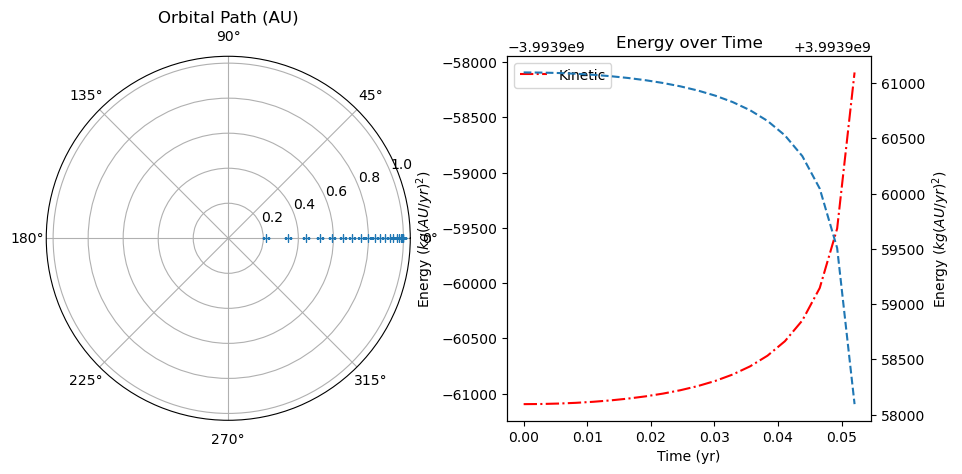

The minimum radial distance is: 0.216421778510881 AU.
The maximum radial distance is: 1.0 AU.
The average energy is: 3993961924.839999 kg(AU/year)^2


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

def rk4(x, t, tau, derivsRK, param, E, l): #changed to accept input parameters E and L, per the ODE
    """
    Runge-Kutta integrator (4th order)
    Input arguments
    :param x: current value of dependent variable
    :param t: independent variable (usually time)
    :param tau: step size (usually time step)
    :param derivsRK: right hand side of the ODE; derivsRK is the name of the function which returns dx/dt
    Calling format derivsRK (x, t, param).
    :param param: estra parameters passed to derivsRK  GM in this case
    :return:
    xout: new value of x after a step of size tau
    """

    half_tau = 0.5*tau
    F1 = derivsRK(x, t, param, E, l)
    t_half = t + half_tau
    xtemp = x + half_tau*F1
    F2 = derivsRK(xtemp, t_half, param, E, l)
    xtemp = x + half_tau*F2
    F3 = derivsRK(xtemp, t_half, param, E, l)
    t_full = t + tau
    xtemp = x + tau*F3
    F4 = derivsRK(xtemp, t_full, param, E, l)
    xout = x + tau/6.0 * (F1 + F4 + 2.0*(F2+F3))

    return xout

def rk4_og(x, t, tau, derivsRK, param): #changed to accept input parameters E and L, per the ODE
    """
    Runge-Kutta integrator (4th order)
    Input arguments
    :param x: current value of dependent variable
    :param t: independent variable (usually time)
    :param tau: step size (usually time step)
    :param derivsRK: right hand side of the ODE; derivsRK is the name of the function which returns dx/dt
    Calling format derivsRK (x, t, param).
    :param param: estra parameters passed to derivsRK  GM in this case
    :return:
    xout: new value of x after a step of size tau
    """

    half_tau = 0.5*tau
    F1 = derivsRK(x, t, param)
    t_half = t + half_tau
    xtemp = x + half_tau*F1
    F2 = derivsRK(xtemp, t_half, param)
    xtemp = x + half_tau*F2
    F3 = derivsRK(xtemp, t_half, param)
    t_full = t + tau
    xtemp = x + tau*F3
    F4 = derivsRK(xtemp, t_full, param)
    xout = x + tau/6.0 * (F1 + F4 + 2.0*(F2+F3))

    return xout

# Define gravrk function used by the Runge-Kutta routines
def gravrk(s, t, GM, E_t, l_t):                #edited so it returns the Schwarzchild ODE
    """ 
    Returns the right-hand side of the Kepler ODE; used by Runge-Kutta routines
    :param s: State vector [r(0), r(1), v(0), v(1)]
    :param t: Time (not used here, included to match derivsRK input)
    :param GM: Parameter G*M - gravitational constant * solar mass Units [AU^3/yr^2]
    :return: deriv: Derivatives [dr(0/dt), dr(1)/dt, dv(0)/dt, dv(1)/dt]
    """

    # Compute acceleration
    r = s[:2]  # Unravel the vector s into position and velocity
    v = s[2:]
    c2 = 63197.8**2 # Speed of light squared, (AU/yr)**2
    #accel = -GM * r / np.linalg.norm(r)**3  Keplerian Gravitational acceleration
    v2 = ((E_t**2/c2)-(1-2*GM/c2/np.linalg.norm(r))*(c2+(l_t**2)/(np.linalg.norm(r)**2)))
    
    accel = (1-2*GM/(np.linalg.norm(r)*c2)) * (((l_t*r/(np.linalg.norm(r))**4) #I am positive this is correct
                                               - ((E_t**2)/c2**2-(v2)/c2)*(GM*r/(np.linalg.norm(r))**3)))

    # Return derivatives
    deriv = np.array([v[0], v[1], accel[0], accel[1]])

    return deriv

def gravrk_K(s, t, GM):                #edited so it returns the Schwarzchild ODE
    """ 
    Returns the right-hand side of the Kepler ODE; used by Runge-Kutta routines
    :param s: State vector [r(0), r(1), v(0), v(1)]
    :param t: Time (not used here, included to match derivsRK input)
    :param GM: Parameter G*M - gravitational constant * solar mass Units [AU^3/yr^2]
    :return: deriv: Derivatives [dr(0/dt), dr(1)/dt, dv(0)/dt, dv(1)/dt]
    """

    # Compute acceleration
    r = s[:2]  # Unravel the vector s into position and velocity
    v = s[2:]
    accel = -GM * r / np.linalg.norm(r)**3  #Keplerian Gravitational acceleration
    
    # Return derivatives
    deriv = np.array([v[0], v[1], accel[0], accel[1]])

    return deriv

# BEGIN SIMULATION: FALLING MASS

# Set physical parameters
GM = 42 * np.pi**2  # Gravitational constant * Mass of sun [AU^3/yr^2] 
G = 2.222e-28       # Gravitational constant [AU^3/yr^2/kg]
M = GM/G            # Calculate mass of star or black hole [kg]
print("The mass of the star / black hole is:", M, "kgs.")
mass = 6e24         # Mass of Earth [kg] (reference mass)
print("The mass of the satellite is:", mass, "kgs.")
c2 = 63197.8**2    # Speed of light squared, [AU/yr]**2  ~3.99e9
R_Schwarz = 2*GM/c2
mu = mass*M/(mass+M)

# Set initial conditions, position and velocity of the comet, E_tilde and l_tilde.   NEED TO FIGURE OUT ORDER OF MAG
r0 = 1               # [AU]
E_tilde = np.sqrt(c2) # [(AU/yr)^2]
l_tilde = 0          # [AU**2/yr] 

v0 = l_tilde/np.linalg.norm(r0)
#print(v0)
r = np.array([r0, 0.0])
v = np.array([0.0, v0])

state = np.array([r[0], r[1], v[0], v[1]])  # State used by R-K routines

time = 0.0
tau = 1/365    #mark out every day for 4 years
nStep = 4*365+1

rplot = np.zeros(nStep)
thplot = np.zeros(nStep)
tplot = np.zeros(nStep)
kinetic = np.zeros(nStep)     #np.empty <-> zeros
potential = np.zeros(nStep)
lplot = np.zeros(nStep)
totalE2 = np.zeros(nStep)

for iStep in tqdm(range(nStep)):

    # Record position and energy for plotting
    rplot[iStep] = np.linalg.norm(r)  # Record radial position and angle for polar plot
    thplot[iStep] = np.arctan2(r[1], r[0])
    tplot[iStep] = time
    kinetic[iStep] = (E_tilde**2/c2)-(1-R_Schwarz/np.linalg.norm(r))*(c2+(l_tilde**2)/(np.linalg.norm(r)**2))  # Record kinetic and potential energy
    potential[iStep] = (1-R_Schwarz/np.linalg.norm(r))*(c2+l_tilde**2/(np.linalg.norm(r)**2)) #3 potential terms and rest energy
    lplot[iStep] = mass*thplot[iStep]*rplot[iStep]**2
    totalE2[iStep] = (kinetic[iStep] + potential[iStep])*c2  # [Energy/mass]^2

    # Calculate new position and velocity using the Runge-Kutta method
    state = rk4(state, time, tau, gravrk, GM, E_tilde, l_tilde)
    r = state[:2]  # 4th Order Runge-Kutta
    v = state[2:]
    time += tau
    
    if np.linalg.norm(r) < R_Schwarz:
        print("The orbiting planet has crossed the event horizon. (Radial alarm)")
        rplot = rplot[:iStep]
        thplot = thplot[:iStep]
        tplot = tplot[:iStep]
        lplot = lplot[:iStep]
        kinetic =  kinetic[:iStep]
        potential = potential[:iStep]
        totalE2 = totalE2[:iStep]
        break
    if (thplot[iStep] - thplot[iStep-1])* 180 / np.pi >= 170:
        print("The orbiting planet has crossed the event horizon. (Angle alarm)")
        print(thplot)
        print(max(thplot))
        
        rplot = rplot[:iStep]
        thplot = thplot[:iStep]
        tplot = tplot[:iStep]
        lplot = lplot[:iStep]
        kinetic =  kinetic[:iStep]
        potential = potential[:iStep]
        totalE2 = totalE2[:iStep]
        
        break

#print(thplot)
        
# Graph the trajectory  and energy of the comet over time.

fig = plt.figure(figsize=(10.0, 5.25))
ax = fig.add_subplot(121, polar=True)
ax.plot(thplot, rplot, '+',)
ax.set_title('Orbital Path (AU)')
ax.grid(True)
fig.tight_layout(pad=5.0)

ax2 = fig.add_subplot(122)
ax3 = ax2.twinx()
ax2.plot(tplot, kinetic, ls='-.', c='r', label='Kinetic')
ax3.plot(tplot, potential, ls='--', label='Potential')
#ax2.plot(tplot, totalE2, ls='-', label='Squared Energy/mass')
#ax3.plot(tplot, lplot, ls='dotted', label='Ang. Mom. ($kg*m^2/s$)', c='r')
ax2.set_title('Energy over Time')
ax2.set_xlabel('Time (yr)')
ax2.set_ylabel(r'Energy ($kg(AU/yr)^2$)')
ax3.set_ylabel(r'Energy ($kg(AU/yr)^2$)')
#ax3.set_ylabel(r'Ang. Mom. ($kg*m^2/s$)')
ax2.legend()

plt.show()

#print(rplot, "\n")
print("The minimum radial distance is:",min(rplot),"AU.")
print("The maximum radial distance is:",max(rplot),"AU.")
print("The average energy is:", np.mean(totalE2), "kg(AU/year)^2")


The mass of the star / black hole is: 1.865541785984487e+30 kgs.
The mass of the satellite is: 6e+24 kgs.
3.0


100%|████████████████████████████████████████████████████████████████████████████| 1461/1461 [00:00<00:00, 6580.34it/s]


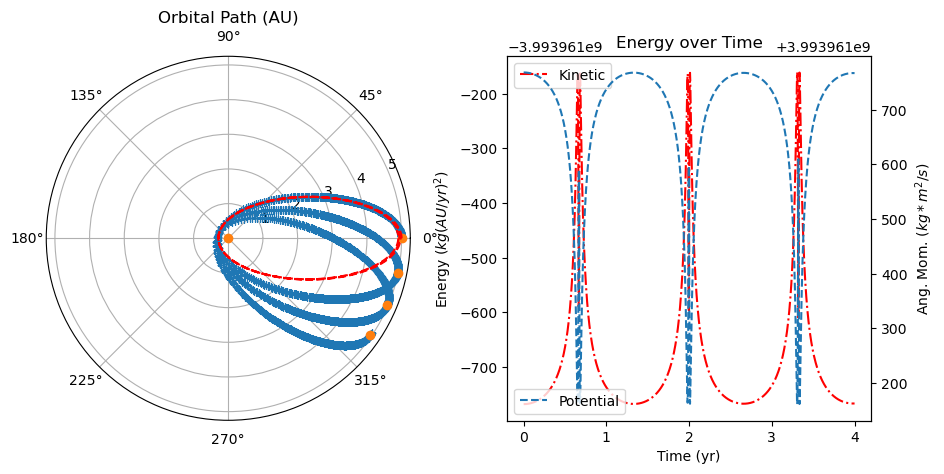

The minimum radial distance is: 0.3073160725694896 AU.
The maximum radial distance is: 5.0 AU.
The average energy is: 3993961924.8399997 kg(AU/year)^2
The planet's orbit precesses by approximately -0.19911045132171099 radians/year.


In [5]:
# BEGIN SIMULATION: Highly Elliptical

# Set physical parameters
GM = 42 * np.pi**2  # Gravitational constant * Mass of sun [AU^3/yr^2] 
G = 2.222e-28       # Gravitational constant [AU^3/yr^2/kg]
M = GM/G            # Calculate mass of star or black hole [kg]
print("The mass of the star / black hole is:", M, "kgs.")
mass = 6e24         # Mass of Earth [kg] (reference mass)
print("The mass of the satellite is:", mass, "kgs.")
c2 = 63197.8**2    # Speed of light squared, [AU/yr]**2  ~3.99e9
R_Schwarz = 2*GM/c2
mu = mass*M/(mass+M)

# Set initial conditions, position and velocity of the comet, E_tilde and l_tilde.   NEED TO FIGURE OUT ORDER OF MAG
r0 = 5               # [AU]
E_tilde = 0 # [(AU/yr)^2]
l_tilde = 15   # [AU**2/yr] 


v0 = l_tilde/np.linalg.norm(r0)
print(v0)
phi_dot = v0
r = np.array([r0, 0.0])
v = np.array([0.0, v0])
r_K = np.array([r0, 0.0])
v_K = np.array([0.0, v0])

state = np.array([r[0], r[1], v[0], v[1]])  # State used by R-K routines
state_K = np.array([r_K[0], r_K[1], v_K[0], v_K[1]])

time = 0.0
tau = 1/365    #mark out every day for 4 years
nStep = 4*365+1

rplot = np.zeros(nStep)     #np.empty <-> zeros
thplot = np.zeros(nStep)
tplot = np.zeros(nStep)
kinetic = np.zeros(nStep)     
potential = np.zeros(nStep)
lplot = np.zeros(nStep)
totalE = np.zeros(nStep)    # total energy

rplot_K = np.zeros(nStep)     #for Keplerian orbits
thplot_K = np.zeros(nStep)
tplot_K = np.zeros(nStep)
time_K = 0.0

th_rmax = np.zeros(5) #arrays to count precession
rmax = np.zeros(5)
j=0 #index for counting precession

for iStep in tqdm(range(nStep)):

    # Record position and energy for plotting
    rplot[iStep] = np.linalg.norm(r)  # Record radial position and angle for polar plot
    thplot[iStep] = np.arctan2(r[1], r[0])
    tplot[iStep] = time
    kinetic[iStep] = (E_tilde**2/c2)-(1-R_Schwarz/np.linalg.norm(r))*(c2+(l_tilde**2)/(np.linalg.norm(r)**2))  # Record kinetic and potential energy
    potential[iStep] = (1-R_Schwarz/np.linalg.norm(r))*(c2+l_tilde**2/(np.linalg.norm(r)**2))
                                            #3 potential terms and rest energy
    phi_dot = l_tilde/rplot[iStep]**2
    lplot[iStep] = mass*rplot[iStep]**2*phi_dot
    #totalE[iStep] = np.sqrt((mass*c2)**2 + kinetic[iStep] + potential[iStep])
    totalE[iStep] = (kinetic[iStep] + potential[iStep]+c2)        # Units: [Energy/mass]^2
    
    if rplot[iStep-1] >= rplot[iStep-2] and rplot[iStep-1] >= rplot[iStep]:
        rmax[j] = rplot[iStep-1]
        th_rmax[j] = thplot[iStep-1]
        #print(thplot[iStep-1], "radians.")
        j+=1

    # Calculate new position and velocity using the Runge-Kutta method
    state = rk4(state, time, tau, gravrk, GM, E_tilde, l_tilde)
    r = state[:2]  # 4th Order Runge-Kutta
    v = state[2:]
    time += tau
    
    #If the orbiting planet crosses the event horizon, cut off arrays
    if np.linalg.norm(r) < R_Schwarz:
        print("The orbiting planet has crossed the event horizon. (Radial alarm)")
        rplot = rplot[:iStep]
        thplot = thplot[:iStep]
        tplot = tplot[:iStep]
        lplot = lplot[:iStep]
        kinetic =  kinetic[:iStep]
        potential = potential[:iStep]
        totalE = totalE[:iStep]
        break
    if (thplot[iStep] - thplot[iStep-1])* 180 / np.pi >= 170:
        print("The orbiting planet has crossed the event horizon. (Angle alarm)")
        print(thplot)
        print(max(thplot))
        
        rplot = rplot[:iStep]
        thplot = thplot[:iStep]
        tplot = tplot[:iStep]
        lplot = lplot[:iStep]
        kinetic =  kinetic[:iStep]
        potential = potential[:iStep]
        totalE = totalE[:iStep]
        break

for iStep in tqdm(range(nStep)):

    # Record position and energy for plotting
    rplot_K[iStep] = np.linalg.norm(r_K)  # Record radial position and angle for polar plot
    thplot_K[iStep] = np.arctan2(r_K[1], r_K[0])
    tplot_K[iStep] = time_K
    
     # Calculate new position and velocity using the Runge-Kutta method
    state_K = rk4_og(state_K, time_K, tau, gravrk_K, GM)
    r_K = state_K[:2]  # 4th Order Runge-Kutta
    v_K = state_K[2:]
    time_K += tau
        
p1 = th_rmax[1] - th_rmax[0]
p2 = th_rmax[2] - th_rmax[1]
p3 = th_rmax[3] - th_rmax[2]
precession = (p1+p2+p3)/3
        
# Graph the trajectory  and energy of the comet over time.

fig = plt.figure(figsize=(10.0, 5.25))
ax = fig.add_subplot(121, polar=True)
ax.plot(thplot, rplot, '+',)
ax.plot(th_rmax, rmax, 'o')
ax.plot(thplot_K, rplot_K, '--', c='r')
ax.set_title('Orbital Path (AU)')
ax.grid(True)
fig.tight_layout(pad=5.0)

ax2 = fig.add_subplot(122)
ax2.plot(tplot, kinetic, ls='-.', c='r', label='Kinetic')
ax3 = ax2.twinx()
ax3.plot(tplot, potential, ls='--', label='Potential')
#ax2.plot(tplot, totalE, ls='-', label='[Energy/mass/c]^2')
#ax3.plot(tplot, lplot, ls='dotted', label='Ang. Mom. ($kg*m^2/s$)', c='r')
ax2.set_title('Energy over Time')
ax2.set_xlabel('Time (yr)')
ax2.set_ylabel(r'Energy ($kg(AU/yr)^2$)')
ax3.set_ylabel(r'Ang. Mom. ($kg*m^2/s$)')
ax2.legend()
ax3.legend()

plt.show()

print("The minimum radial distance is:",min(rplot),"AU.")
print("The maximum radial distance is:",max(rplot),"AU.")
print("The average energy is:", np.mean(totalE), "kg(AU/year)^2")
print("The planet's orbit precesses by approximately", precession, "radians/year.")


The mass of the star / black hole is: 1.865541785984487e+30 kgs.
The mass of the satellite is: 6e+24 kgs.
8.4


100%|████████████████████████████████████████████████████████████████████████████| 1461/1461 [00:00<00:00, 6591.79it/s]


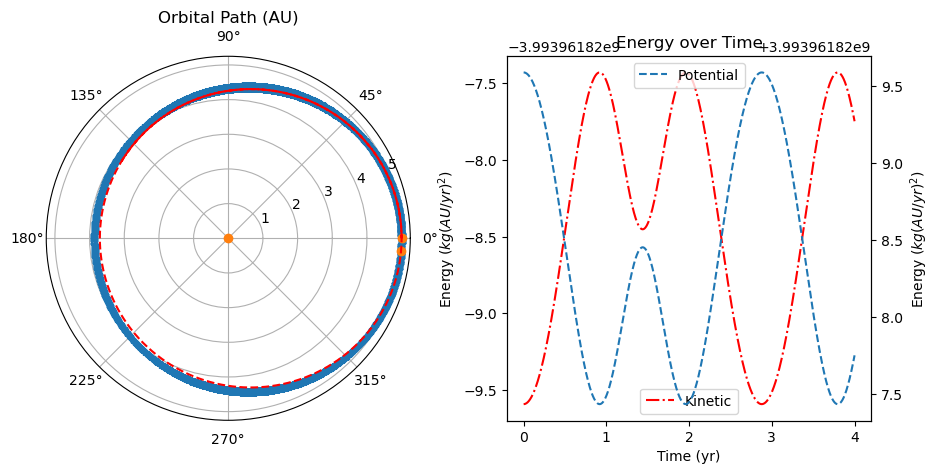

The minimum radial distance is: 3.8602390859917834 AU.
The maximum radial distance is: 5.0 AU.
The average energy is: 3993961924.8399997 kg(AU/year)^2
The planet's orbit precesses by: -0.07496006685418748 radians/year.


In [6]:
# BEGIN SIMULATION: Slight Ellipse

# Set physical parameters
GM = 42 * np.pi**2  # Gravitational constant * Mass of sun [AU^3/yr^2] 
G = 2.222e-28       # Gravitational constant [AU^3/yr^2/kg]
M = GM/G            # Calculate mass of star or black hole [kg]
print("The mass of the star / black hole is:", M, "kgs.")
mass = 6e24         # Mass of Earth [kg] (reference mass)
print("The mass of the satellite is:", mass, "kgs.")
c2 = 63197.8**2    # Speed of light squared, [AU/yr]**2  ~3.99e9
R_Schwarz = 2*GM/c2
mu = mass*M/(mass+M)

# Set initial conditions, position and velocity of the comet, E_tilde and l_tilde.   NEED TO FIGURE OUT ORDER OF MAG
r0 = 5               # [AU]
E_tilde = 0 # [(AU/yr)^2]
l_tilde = 42   # [AU**2/yr] 


v0 = l_tilde/np.linalg.norm(r0)
print(v0)
phi_dot = v0
r = np.array([r0, 0.0])
v = np.array([0.0, v0])

state = np.array([r[0], r[1], v[0], v[1]])  # State used by R-K routines

time = 0.0
tau = 1/365    #mark out every day for 4 years
nStep = 4*365+1

rplot = np.zeros(nStep)
thplot = np.zeros(nStep)
tplot = np.zeros(nStep)
kinetic = np.zeros(nStep)     #np.empty <-> zeros
potential = np.zeros(nStep)
lplot = np.zeros(nStep)
totalE = np.zeros(nStep)  # total energy

rplot_K = np.zeros(nStep)     #for Keplerian orbits
thplot_K = np.zeros(nStep)
tplot_K = np.zeros(nStep)
time_K = 0.0
r_K = np.array([r0, 0.0])
v_K = np.array([0.0, v0])
state_K = np.array([r_K[0], r_K[1], v_K[0], v_K[1]])

th_rmax = np.zeros(3) #arrays to count precession
rmax = np.zeros(3)
j=0 #index for counting precession

for iStep in tqdm(range(nStep)):

    # Record position and energy for plotting
    rplot[iStep] = np.linalg.norm(r)  # Record radial position and angle for polar plot
    thplot[iStep] = np.arctan2(r[1], r[0])
    tplot[iStep] = time
    kinetic[iStep] = (E_tilde**2/c2)-(1-R_Schwarz/np.linalg.norm(r))*(c2+(l_tilde**2)/(np.linalg.norm(r)**2))  # Record kinetic and potential energy
    potential[iStep] = (1-R_Schwarz/np.linalg.norm(r))*(c2+l_tilde**2/(np.linalg.norm(r)**2))
                                            #3 potential terms and rest energy
    phi_dot = l_tilde/rplot[iStep]**2
    lplot[iStep] = mass*rplot[iStep]**2*phi_dot
    #totalE[iStep] = np.sqrt((mass*c2)**2 + kinetic[iStep] + potential[iStep])
    totalE[iStep] = (kinetic[iStep] + potential[iStep]+c2)        # Units: [Energy/mass]^2

    if rplot[iStep-1] >= rplot[iStep-2] and rplot[iStep-1] >= rplot[iStep]:
        rmax[j] = rplot[iStep-1]
        th_rmax[j] = thplot[iStep-1]
        #print(thplot[iStep-1], "radians.")
        j+=1
    
    # Calculate new position and velocity using the Runge-Kutta method
    state = rk4(state, time, tau, gravrk, GM, E_tilde, l_tilde)
    r = state[:2]  # 4th Order Runge-Kutta
    v = state[2:]
    time += tau
    
    #if totalE[iStep] 
    if np.linalg.norm(r) < R_Schwarz:
        print("The orbiting planet has crossed the event horizon. (Radial alarm)")
        rplot = rplot[:iStep]
        thplot = thplot[:iStep]
        tplot = tplot[:iStep]
        lplot = lplot[:iStep]
        kinetic =  kinetic[:iStep]
        potential = potential[:iStep]
        totalE = totalE[:iStep]
        break
    if (thplot[iStep] - thplot[iStep-1])* 180 / np.pi >= 170:
        print("The orbiting planet has crossed the event horizon. (Angle alarm)")
        print(thplot)
        print(max(thplot))
        
        rplot = rplot[:iStep]
        thplot = thplot[:iStep]
        tplot = tplot[:iStep]
        lplot = lplot[:iStep]
        kinetic =  kinetic[:iStep]
        potential = potential[:iStep]
        totalE = totalE[:iStep]
        break

for iStep in tqdm(range(nStep)):

    # Record position and energy for plotting
    rplot_K[iStep] = np.linalg.norm(r_K)  # Record radial position and angle for polar plot
    thplot_K[iStep] = np.arctan2(r_K[1], r_K[0])
    tplot_K[iStep] = time_K
    
     # Calculate new position and velocity using the Runge-Kutta method
    state_K = rk4_og(state_K, time_K, tau, gravrk_K, GM)
    r_K = state_K[:2]  # 4th Order Runge-Kutta
    v_K = state_K[2:]
    time_K += tau        
        
# Graph the trajectory  and energy of the comet over time.

fig = plt.figure(figsize=(10.0, 5.25))
ax = fig.add_subplot(121, polar=True)
ax.plot(thplot, rplot, '+',)
ax.plot(th_rmax, rmax, 'o')
ax.plot(thplot_K, rplot_K, '--', c='r')
ax.set_title('Orbital Path (AU)')
ax.grid(True)
fig.tight_layout(pad=5.0)

ax2 = fig.add_subplot(122)
ax2.plot(tplot, kinetic, ls='-.', c='r', label='Kinetic')
ax3 = ax2.twinx()
ax3.plot(tplot, potential, ls='--', label='Potential')
#ax2.plot(tplot, totalE, ls='-', label='[Energy/mass/c]^2')
#ax3.plot(tplot, lplot, ls='dotted', label='Ang. Mom. ($kg*m^2/s$)', c='r')
ax2.set_title('Energy over Time')
ax2.set_xlabel('Time (yr)')
ax2.set_ylabel(r'Energy ($kg(AU/yr)^2$)')
ax3.set_ylabel(r'Energy ($kg(AU/yr)^2$)')
#ax3.set_ylabel(r'Ang. Mom. ($kg*m^2/s$)')
ax2.legend()
ax3.legend()

plt.show()

print("The minimum radial distance is:",min(rplot),"AU.")
print("The maximum radial distance is:",max(rplot),"AU.")
print("The average energy is:", np.mean(totalE), "kg(AU/year)^2")
print("The planet's orbit precesses by:",th_rmax[1],"radians/year.")


The mass of the star / black hole is: 1.865541785984487e+30 kgs.
The mass of the satellite is: 6e+24 kgs.
The Schwarzchild radius is: 2.0757503083225263e-07 AU.
The initial orbital velocity is 9.005752 AU/yr


100%|████████████████████████████████████████████████████████████████████████████| 1461/1461 [00:00<00:00, 5880.90it/s]


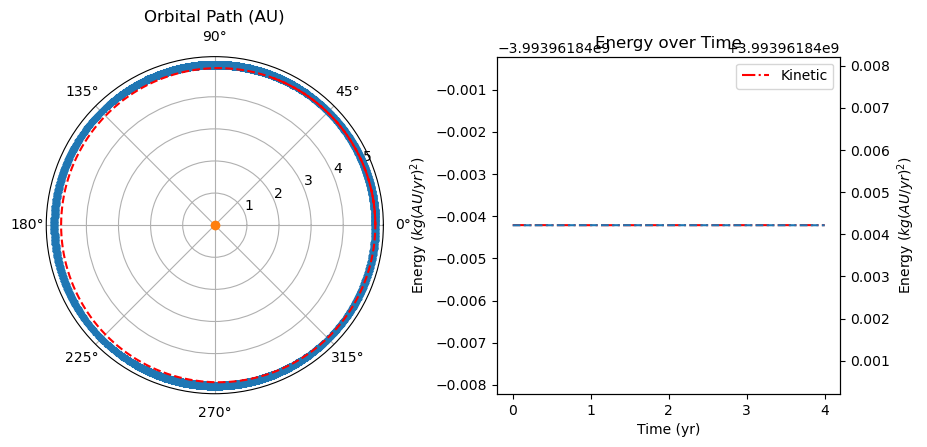

The minimum radial distance is: 5.0 AU.
The maximum radial distance is: 5.000005746464661 AU.
The average energy is: 3993961924.8399997 kg(AU/year)^2


In [7]:
# BEGIN SIMULATION: Circular

# Set physical parameters
GM = 42 * np.pi**2  # Gravitational constant * Mass of sun [AU^3/yr^2] 
G = 2.222e-28       # Gravitational constant [AU^3/yr^2/kg]
M = GM/G            # Calculate mass of star or black hole [kg]
print("The mass of the star / black hole is:", M, "kgs.")
mass = 6e24         # Mass of Earth [kg] (reference mass)
print("The mass of the satellite is:", mass, "kgs.")
c2 = 63197.8**2    # Speed of light squared, [AU/yr]**2  ~3.99e9
R_Schwarz = 2*GM/c2
print("The Schwarzchild radius is:", R_Schwarz, "AU.")
mu = mass*M/(mass+M)

# Set initial conditions, position and velocity of the comet, E_tilde and l_tilde.   NEED TO FIGURE OUT ORDER OF MAG
r0 = 5                                  # [AU]
E_tilde = 0                             # [(AU/yr)^2]
l_tilde = 45.02876                      # [AU**2/yr] Experimented w/ value until orbit was circular (Error: 10e-6)

v0 = l_tilde/np.linalg.norm(r0)
print("The initial orbital velocity is",v0, "AU/yr")
phi_dot = v0
r = np.array([r0, 0.0])
v = np.array([0.0, v0])

state = np.array([r[0], r[1], v[0], v[1]])  # State used by R-K routines

time = 0.0
tau = 1/365    #mark out every day for 4 years
nStep = 4*365+1

rplot = np.zeros(nStep)
thplot = np.zeros(nStep)
tplot = np.zeros(nStep)
kinetic = np.zeros(nStep)     #np.empty <-> zeros
potential = np.zeros(nStep)
lplot = np.zeros(nStep)
totalE = np.zeros(nStep)  # total energy

rplot_K = np.zeros(nStep)     #for Keplerian orbits
thplot_K = np.zeros(nStep)
tplot_K = np.zeros(nStep)
time_K = 0.0
r_K = np.array([r0, 0.0])
v_K = np.array([0.0, v0])
state_K = np.array([r_K[0], r_K[1], v_K[0], v_K[1]])

for iStep in tqdm(range(nStep)):

    # Record position and energy for plotting
    rplot[iStep] = np.linalg.norm(r)  # Record radial position and angle for polar plot
    thplot[iStep] = np.arctan2(r[1], r[0])
    tplot[iStep] = time
    kinetic[iStep] = (E_tilde**2/c2)-(1-R_Schwarz/np.linalg.norm(r))*(c2+(l_tilde**2)/(np.linalg.norm(r)**2))  # Record kinetic and potential energy
    potential[iStep] = (1-R_Schwarz/np.linalg.norm(r))*(c2+l_tilde**2/(np.linalg.norm(r)**2))
                                            #3 potential terms and rest energy
    phi_dot = l_tilde/rplot[iStep]**2
    lplot[iStep] = mass*rplot[iStep]**2*phi_dot
    #totalE[iStep] = np.sqrt((mass*c2)**2 + kinetic[iStep] + potential[iStep])
    totalE[iStep] = (kinetic[iStep] + potential[iStep]+c2)        # Units: [Energy/mass]^2

    # Calculate new position and velocity using the Runge-Kutta method
    state = rk4(state, time, tau, gravrk, GM, E_tilde, l_tilde)
    r = state[:2]  # 4th Order Runge-Kutta
    v = state[2:]
    time += tau
    
    #if totalE[iStep] 
    if np.linalg.norm(r) < R_Schwarz:
        print("The orbiting planet has crossed the event horizon. (Radial alarm)")
        rplot = rplot[:iStep]
        thplot = thplot[:iStep]
        tplot = tplot[:iStep]
        lplot = lplot[:iStep]
        kinetic =  kinetic[:iStep]
        potential = potential[:iStep]
        totalE = totalE[:iStep]
        break
    if (thplot[iStep] - thplot[iStep-1])* 180 / np.pi >= 170:
        print("The orbiting planet has crossed the event horizon. (Angle alarm)")
        print(thplot)
        print(max(thplot))
        
        rplot = rplot[:iStep]
        thplot = thplot[:iStep]
        tplot = tplot[:iStep]
        lplot = lplot[:iStep]
        kinetic =  kinetic[:iStep]
        potential = potential[:iStep]
        totalE = totalE[:iStep]
        break

for iStep in tqdm(range(nStep)):

    # Record position and energy for plotting
    rplot_K[iStep] = np.linalg.norm(r_K)  # Record radial position and angle for polar plot
    thplot_K[iStep] = np.arctan2(r_K[1], r_K[0])
    tplot_K[iStep] = time_K
    
     # Calculate new position and velocity using the Runge-Kutta method
    state_K = rk4_og(state_K, time_K, tau, gravrk_K, GM)
    r_K = state_K[:2]  # 4th Order Runge-Kutta
    v_K = state_K[2:]
    time_K += tau 
        
# Graph the trajectory  and energy of the comet over time.

fig = plt.figure(figsize=(10.0, 5.25))
ax = fig.add_subplot(121, polar=True)
ax.plot(thplot, rplot, '+',)
ax.plot(0,0,'o')
ax.plot(thplot_K, rplot_K, '--', c='r')
ax.set_title('Orbital Path (AU)')
ax.grid(True)
fig.tight_layout(pad=6.0)

ax2 = fig.add_subplot(122)
ax2.plot(tplot, kinetic, ls='-.', c='r', label='Kinetic')
ax3 = ax2.twinx()
ax3.plot(tplot, potential, ls='--', label='Potential')
#ax2.plot(tplot, totalE, ls='-', label='[Energy/mass/c]^2')
#ax3.plot(tplot, lplot, ls='dotted', label='Ang. Mom. ($kg*m^2/s$)', c='r')
ax2.set_title('Energy over Time')
ax2.set_xlabel('Time (yr)')
ax2.set_ylabel(r'Energy ($kg(AU/yr)^2$)')
ax3.set_ylabel(r'Energy ($kg(AU/yr)^2$)')
#ax3.set_ylabel(r'Ang. Mom. ($kg*m^2/s$)')
ax2.legend()

plt.show()

print("The minimum radial distance is:",min(rplot),"AU.")
print("The maximum radial distance is:",max(rplot),"AU.") #Error is roughly 150 km
print("The average energy is:", np.mean(totalE), "kg(AU/year)^2")


The mass of the star / black hole is: 1.865541785984487e+30 kgs.
The mass of the satellite is: 6e+24 kgs.
v0= 3.0


100%|██████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 7161.23it/s]


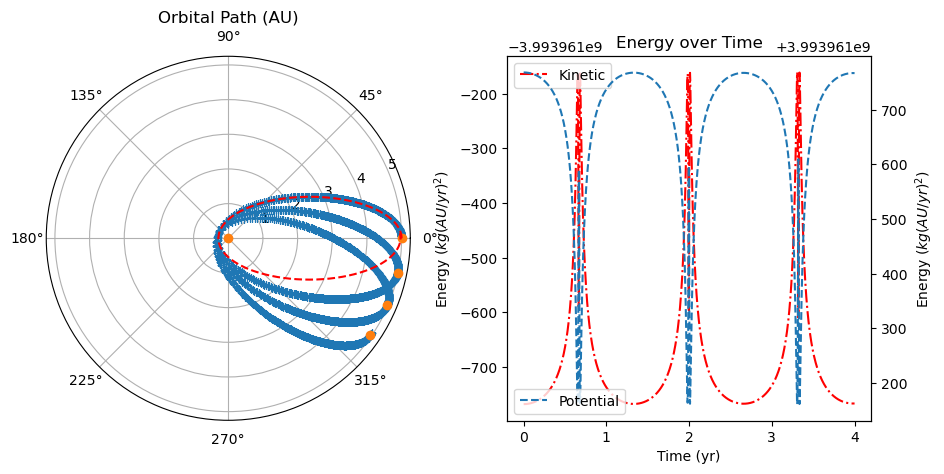

The minimum radial distance is: 0.3073160725694896 AU.
The maximum radial distance is: 5.0 AU.
The planet's orbit precesses by approximately -0.19911045132171099 radians/year.
The eccentricity of the orbit is 0.8914260781999512 .


In [79]:
# BEGIN SIMULATION: Highly Elliptical with Keplerian Comparison

# Set physical parameters
GM = 42 * np.pi**2  # Gravitational constant * Mass of sun [AU^3/yr^2] 
G = 2.222e-28       # Gravitational constant [AU^3/yr^2/kg]
M = GM/G            # Calculate mass of star or black hole [kg]
print("The mass of the star / black hole is:", M, "kgs.")
mass = 6e24         # Mass of Earth [kg] (reference mass)
print("The mass of the satellite is:", mass, "kgs.")
c2 = 63197.8**2    # Speed of light squared, [AU/yr]**2  ~3.99e9
R_Schwarz = 2*GM/c2
mu = mass*M/(mass+M)

# Set initial conditions, position and velocity of the comet, E_tilde and l_tilde.   NEED TO FIGURE OUT ORDER OF MAG
r0 = 5               # [AU]
E_tilde = 0 # [(AU/yr)^2]
l_tilde = 15   # [AU**2/yr] 


v0 = l_tilde/np.linalg.norm(r0)
print("v0=",v0)
phi_dot = v0
r = np.array([r0, 0.0])
v = np.array([0.0, v0])
r_K = np.array([r0, 0.0])
v_K = np.array([0.0, v0])

state = np.array([r[0], r[1], v[0], v[1]])  # State used by R-K routines
state_K = np.array([r_K[0], r_K[1], v_K[0], v_K[1]]) #State vector for Kepler comparison

time = 0.0
time_K = 0.0
tau = 1/365    #mark out every day for 4 years
nStep = 4*365+1

rplot = np.zeros(nStep)     #np.empty <-> zeros
thplot = np.zeros(nStep)
tplot = np.zeros(nStep)
rplot_K = np.zeros(500)     #Kepler Arrays
thplot_K = np.zeros(500)
tplot_K = np.zeros(500)
kinetic = np.zeros(nStep)   #Energy Arrays  
potential = np.zeros(nStep)
lplot = np.zeros(nStep)
totalE = np.zeros(nStep)    # total energy

th_rmax = np.zeros(5) #arrays to count precession
rmax = np.zeros(5)
j=0 #index for counting precession

for iStep in tqdm(range(nStep)):

    # Record position and energy for plotting
    rplot[iStep] = np.linalg.norm(r)  # Record radial position and angle for polar plot
    thplot[iStep] = np.arctan2(r[1], r[0])
    tplot[iStep] = time
    kinetic[iStep] = (E_tilde**2/c2)-(1-R_Schwarz/np.linalg.norm(r))*(c2+(l_tilde**2)/(np.linalg.norm(r)**2))  # Record kinetic and potential energy
    potential[iStep] = (1-R_Schwarz/np.linalg.norm(r))*(c2+l_tilde**2/(np.linalg.norm(r)**2))
                                            #3 potential terms and rest energy
    phi_dot = l_tilde/rplot[iStep]**2
    lplot[iStep] = mass*rplot[iStep]**2*phi_dot
    #totalE[iStep] = np.sqrt((mass*c2)**2 + kinetic[iStep] + potential[iStep])
    totalE[iStep] = (kinetic[iStep] + potential[iStep]+c2)        # Units: [Energy/mass]^2
    
    if rplot[iStep-1] >= rplot[iStep-2] and rplot[iStep-1] >= rplot[iStep]:
        rmax[j] = rplot[iStep-1]
        th_rmax[j] = thplot[iStep-1]
        #print(thplot[iStep-1], "radians.")
        j+=1

    # Calculate new position and velocity using the Runge-Kutta method
    state = rk4(state, time, tau, gravrk, GM, E_tilde, l_tilde) 
    r = state[:2]  # 4th Order Runge-Kutta
    v = state[2:]
    time += tau
    
    #if totalE[iStep] 
    if np.linalg.norm(r) < R_Schwarz:
        print("The orbiting planet has crossed the event horizon. (Radial alarm)")
        rplot = rplot[:iStep]
        thplot = thplot[:iStep]
        tplot = tplot[:iStep]
        lplot = lplot[:iStep]
        kinetic =  kinetic[:iStep]
        potential = potential[:iStep]
        totalE = totalE[:iStep]
        break
    if (thplot[iStep] - thplot[iStep-1])* 180 / np.pi >= 170:
        print("The orbiting planet has crossed the event horizon. (Angle alarm)")
        print(thplot)
        print(max(thplot))
        
        rplot = rplot[:iStep]
        thplot = thplot[:iStep]
        tplot = tplot[:iStep]
        lplot = lplot[:iStep]
        kinetic =  kinetic[:iStep]
        potential = potential[:iStep]
        totalE = totalE[:iStep]
        break

for iStep in tqdm(range(500)):

    # Record position and energy for plotting
    rplot_K[iStep] = np.linalg.norm(r_K)  # Record radial position and angle for polar plot
    thplot_K[iStep] = np.arctan2(r_K[1], r_K[0])
    tplot_K[iStep] = time_K

    # Calculate new position and velocity using the Runge-Kutta method
    state_K = rk4_og(state_K, time_K, tau, gravrk_K, GM) #need a different gravrk here
    r_K = state_K[:2]  # 4th Order Runge-Kutta
    v_K = state_K[2:]
    time_K += tau        
        
p1 = th_rmax[1] - th_rmax[0]
p2 = th_rmax[2] - th_rmax[1]
p3 = th_rmax[3] - th_rmax[2]
precession = (p1+p2+p3)/3

eccent = 2/(1+min(rplot_K)/r0)-1
        
# Graph the trajectory  and energy of the comet over time.

fig = plt.figure(figsize=(10.0, 5.25))
ax = fig.add_subplot(121, polar=True)
ax.plot(thplot, rplot, '+',)
ax.plot(th_rmax, rmax, 'o')
ax.plot(thplot_K, rplot_K, '--', c='r')
ax.set_title('Orbital Path (AU)')
ax.grid(True)
fig.tight_layout(pad=5.0)

ax2 = fig.add_subplot(122)
ax2.plot(tplot, kinetic, ls='-.', c='r', label='Kinetic')
ax3 = ax2.twinx()
ax3.plot(tplot, potential, ls='--', label='Potential')
#ax2.plot(tplot, totalE, ls='-', label='[Energy/mass/c]^2')
#ax3.plot(tplot, lplot, ls='dotted', label='Ang. Mom. ($kg*m^2/s$)', c='r')
ax2.set_title('Energy over Time')
ax2.set_xlabel('Time (yr)')
ax2.set_ylabel(r'Energy ($kg(AU/yr)^2$)')
ax3.set_ylabel(r'Energy ($kg(AU/yr)^2$)')
#ax3.set_ylabel(r'Ang. Mom. ($kg*m^2/s$)')
ax2.legend()
ax3.legend()

plt.show()

print("The minimum radial distance is:",min(rplot),"AU.")
print("The maximum radial distance is:",max(rplot),"AU.")
print("The planet's orbit precesses by approximately", precession, "radians/year.")
print("The eccentricity of the orbit is", eccent, ".")


The mass of the star / black hole is: 1.865541785984487e+30 kgs.
The mass of the satellite is: 6e+24 kgs.
v0= 8.4


100%|████████████████████████████████████████████████████████████████████████████| 1100/1100 [00:00<00:00, 6980.24it/s]


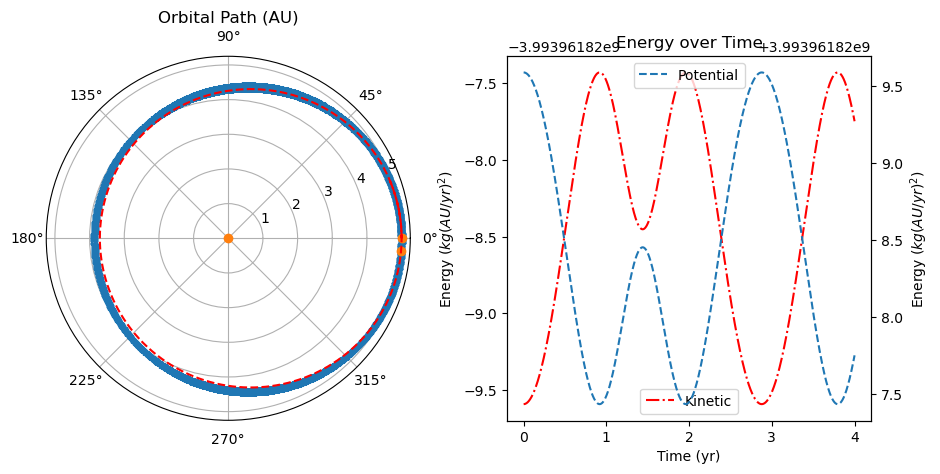

The minimum radial distance is: 3.8602390859917834 AU.
The maximum radial distance is: 5.0 AU.
The planet's orbit precesses by approximately -0.07496006685418748 radians/year.
The eccentricity of the orbit is 0.148901819129029 .


In [77]:
# BEGIN SIMULATION: Slightly Elliptical with Keplerian Comparison

# Set physical parameters
GM = 42 * np.pi**2  # Gravitational constant * Mass of sun [AU^3/yr^2] 
G = 2.222e-28       # Gravitational constant [AU^3/yr^2/kg]
M = GM/G            # Calculate mass of star or black hole [kg]
print("The mass of the star / black hole is:", M, "kgs.")
mass = 6e24         # Mass of Earth [kg] (reference mass)
print("The mass of the satellite is:", mass, "kgs.")
c2 = 63197.8**2    # Speed of light squared, [AU/yr]**2  ~3.99e9
R_Schwarz = 2*GM/c2
mu = mass*M/(mass+M)

# Set initial conditions, position and velocity of the comet, E_tilde and l_tilde.   NEED TO FIGURE OUT ORDER OF MAG
r0 = 5               # [AU]
E_tilde = 0 # [(AU/yr)^2]
l_tilde = 42   # [AU**2/yr] 


v0 = l_tilde/np.linalg.norm(r0)
print("v0=",v0)
phi_dot = v0
r = np.array([r0, 0.0])
v = np.array([0.0, v0])
r_K = np.array([r0, 0.0])
v_K = np.array([0.0, v0])

state = np.array([r[0], r[1], v[0], v[1]])  # State used by R-K routines
state_K = np.array([r_K[0], r_K[1], v_K[0], v_K[1]]) #State vector for Kepler comparison

time = 0.0
time_K = 0.0
tau = 1/365    #mark out every day for 4 years
nStep = 4*365+1

rplot = np.zeros(nStep)     #np.empty <-> zeros
thplot = np.zeros(nStep)
tplot = np.zeros(nStep)
rplot_K = np.zeros(1100)     #Kepler Arrays
thplot_K = np.zeros(1100)
tplot_K = np.zeros(1100)
kinetic = np.zeros(nStep)   #Energy Arrays  
potential = np.zeros(nStep)
lplot = np.zeros(nStep)
totalE = np.zeros(nStep)    # total energy

th_rmax = np.zeros(3) #arrays to count precession
rmax = np.zeros(3)
j=0 #index for counting precession

for iStep in tqdm(range(nStep)):

    # Record position and energy for plotting
    rplot[iStep] = np.linalg.norm(r)  # Record radial position and angle for polar plot
    thplot[iStep] = np.arctan2(r[1], r[0])
    tplot[iStep] = time
    kinetic[iStep] = (E_tilde**2/c2)-(1-R_Schwarz/np.linalg.norm(r))*(c2+(l_tilde**2)/(np.linalg.norm(r)**2))  # Record kinetic and potential energy
    potential[iStep] = (1-R_Schwarz/np.linalg.norm(r))*(c2+l_tilde**2/(np.linalg.norm(r)**2))
                                            #3 potential terms and rest energy
    phi_dot = l_tilde/rplot[iStep]**2
    lplot[iStep] = mass*rplot[iStep]**2*phi_dot
    #totalE[iStep] = np.sqrt((mass*c2)**2 + kinetic[iStep] + potential[iStep])
    totalE[iStep] = (kinetic[iStep] + potential[iStep]+c2)        # Units: [Energy/mass]^2
    
    if rplot[iStep-1] >= rplot[iStep-2] and rplot[iStep-1] >= rplot[iStep]:
        rmax[j] = rplot[iStep-1]
        th_rmax[j] = thplot[iStep-1]
        #print(thplot[iStep-1], "radians.")
        j+=1

    # Calculate new position and velocity using the Runge-Kutta method
    state = rk4(state, time, tau, gravrk, GM, E_tilde, l_tilde) 
    r = state[:2]  # 4th Order Runge-Kutta
    v = state[2:]
    time += tau
    
    #if totalE[iStep] 
    if np.linalg.norm(r) < R_Schwarz:
        print("The orbiting planet has crossed the event horizon. (Radial alarm)")
        rplot = rplot[:iStep]
        thplot = thplot[:iStep]
        tplot = tplot[:iStep]
        lplot = lplot[:iStep]
        kinetic =  kinetic[:iStep]
        potential = potential[:iStep]
        totalE = totalE[:iStep]
        break
    if (thplot[iStep] - thplot[iStep-1])* 180 / np.pi >= 170:
        print("The orbiting planet has crossed the event horizon. (Angle alarm)")
        print(thplot)
        print(max(thplot))
        
        rplot = rplot[:iStep]
        thplot = thplot[:iStep]
        tplot = tplot[:iStep]
        lplot = lplot[:iStep]
        kinetic =  kinetic[:iStep]
        potential = potential[:iStep]
        totalE = totalE[:iStep]
        break

for iStep in tqdm(range(1100)):

    # Record position and energy for plotting
    rplot_K[iStep] = np.linalg.norm(r_K)  # Record radial position and angle for polar plot
    thplot_K[iStep] = np.arctan2(r_K[1], r_K[0])
    tplot_K[iStep] = time_K

    # Calculate new position and velocity using the Runge-Kutta method
    state_K = rk4_og(state_K, time_K, tau, gravrk_K, GM) #need a different gravrk here
    r_K = state_K[:2]  # 4th Order Runge-Kutta
    v_K = state_K[2:]
    time_K += tau        
        
eccent = 2/(1+min(rplot_K)/r0)-1
        
# Graph the trajectory  and energy of the comet over time.

fig = plt.figure(figsize=(10.0, 5.25))
ax = fig.add_subplot(121, polar=True)
ax.plot(thplot, rplot, '+',)
ax.plot(th_rmax, rmax, 'o')
ax.plot(thplot_K, rplot_K, '--', c='r')
ax.set_title('Orbital Path (AU)')
ax.grid(True)
fig.tight_layout(pad=5.0)

ax2 = fig.add_subplot(122)
ax2.plot(tplot, kinetic, ls='-.', c='r', label='Kinetic')
ax3 = ax2.twinx()
ax3.plot(tplot, potential, ls='--', label='Potential')
#ax2.plot(tplot, totalE, ls='-', label='[Energy/mass/c]^2')
#ax3.plot(tplot, lplot, ls='dotted', label='Ang. Mom. ($kg*m^2/s$)', c='r')
ax2.set_title('Energy over Time')
ax2.set_xlabel('Time (yr)')
ax2.set_ylabel(r'Energy ($kg(AU/yr)^2$)')
ax3.set_ylabel(r'Energy ($kg(AU/yr)^2$)')
#ax3.set_ylabel(r'Ang. Mom. ($kg*m^2/s$)')
ax2.legend()
ax3.legend()

plt.show()

print("The minimum radial distance is:",min(rplot),"AU.")
print("The maximum radial distance is:",max(rplot),"AU.")
print("The planet's orbit precesses by approximately", th_rmax[1], "radians/year.")
print("The eccentricity of the orbit is", eccent, ".")


The mass of the star / black hole is: 1.865541785984487e+30 kgs.
The mass of the satellite is: 6e+24 kgs.
v0= 9.00575


100%|████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:00<00:00, 8027.34it/s]


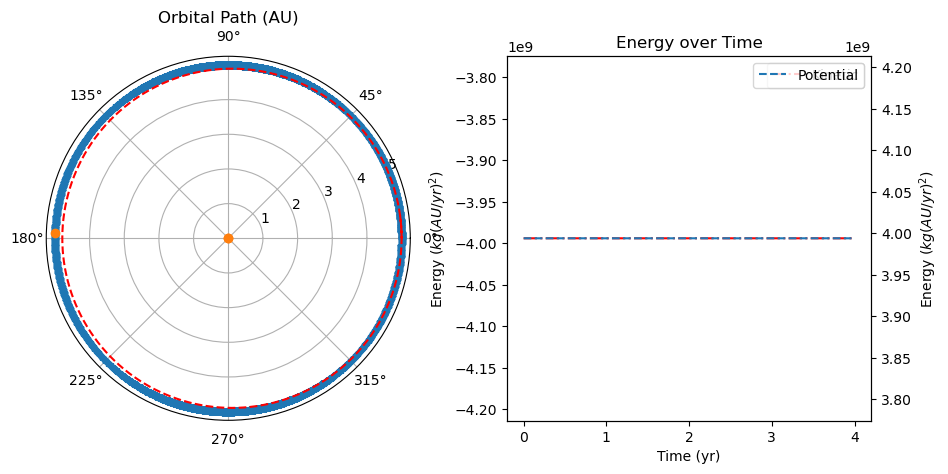

The minimum radial distance is: 4.999999999998722 AU.
The maximum radial distance is: 5.000001353104859 AU.
The planet's orbit precesses by approximately 0.0 radians/year.


In [85]:
# BEGIN SIMULATION: Circular with Keplerian Comparison

# Set physical parameters
GM = 42 * np.pi**2  # Gravitational constant * Mass of sun [AU^3/yr^2] 
G = 2.222e-28       # Gravitational constant [AU^3/yr^2/kg]
M = GM/G            # Calculate mass of star or black hole [kg]
print("The mass of the star / black hole is:", M, "kgs.")
mass = 6e24         # Mass of Earth [kg] (reference mass)
print("The mass of the satellite is:", mass, "kgs.")
c2 = 63197.8**2    # Speed of light squared, [AU/yr]**2  ~3.99e9
R_Schwarz = 2*GM/c2
mu = mass*M/(mass+M)

# Set initial conditions, position and velocity of the comet, E_tilde and l_tilde.   NEED TO FIGURE OUT ORDER OF MAG
r0 = 5               # [AU]
E_tilde = 0 # [(AU/yr)^2]
l_tilde = 45.02875   # [AU**2/yr] 


v0 = l_tilde/np.linalg.norm(r0)
print("v0=",v0)
phi_dot = v0
r = np.array([r0, 0.0])
v = np.array([0.0, v0])
r_K = np.array([r0, 0.0])
v_K = np.array([0.0, v0])

state = np.array([r[0], r[1], v[0], v[1]])  # State used by R-K routines
state_K = np.array([r_K[0], r_K[1], v_K[0], v_K[1]]) #State vector for Kepler comparison

time = 0.0
time_K = 0.0
tau = 1/365    #mark out every day for 4 years
nStep = 4*365+1

rplot = np.zeros(nStep)     #np.empty <-> zeros
thplot = np.zeros(nStep)
tplot = np.zeros(nStep)
rplot_K = np.zeros(1250)     #Kepler Arrays
thplot_K = np.zeros(1250)
tplot_K = np.zeros(1250)
kinetic = np.zeros(nStep)   #Energy Arrays  
potential = np.zeros(nStep)
lplot = np.zeros(nStep)
totalE = np.zeros(nStep)    # total energy

th_rmax = np.zeros(3) #arrays to count precession
rmax = np.zeros(3)
j=0 #index for counting precession

for iStep in tqdm(range(nStep)):

    # Record position and energy for plotting
    rplot[iStep] = np.linalg.norm(r)  # Record radial position and angle for polar plot
    thplot[iStep] = np.arctan2(r[1], r[0])
    tplot[iStep] = time
    kinetic[iStep] = (E_tilde**2/c2)-(1-R_Schwarz/np.linalg.norm(r))*(c2+(l_tilde**2)/(np.linalg.norm(r)**2))  # Record kinetic and potential energy
    potential[iStep] = (1-R_Schwarz/np.linalg.norm(r))*(c2+l_tilde**2/(np.linalg.norm(r)**2))
                                            #3 potential terms and rest energy
    phi_dot = l_tilde/rplot[iStep]**2
    lplot[iStep] = mass*rplot[iStep]**2*phi_dot
    #totalE[iStep] = np.sqrt((mass*c2)**2 + kinetic[iStep] + potential[iStep])
    totalE[iStep] = (kinetic[iStep] + potential[iStep]+c2)        # Units: [Energy/mass]^2
    
    if rplot[iStep-1] >= rplot[iStep-2] and rplot[iStep-1] >= rplot[iStep]:
        rmax[j] = rplot[iStep-1]
        th_rmax[j] = thplot[iStep-1]
        #print(thplot[iStep-1], "radians.")
        j+=1

    # Calculate new position and velocity using the Runge-Kutta method
    state = rk4(state, time, tau, gravrk, GM, E_tilde, l_tilde) 
    r = state[:2]  # 4th Order Runge-Kutta
    v = state[2:]
    time += tau
    
    #if totalE[iStep] 
    if np.linalg.norm(r) < R_Schwarz:
        print("The orbiting planet has crossed the event horizon. (Radial alarm)")
        rplot = rplot[:iStep]
        thplot = thplot[:iStep]
        tplot = tplot[:iStep]
        lplot = lplot[:iStep]
        kinetic =  kinetic[:iStep]
        potential = potential[:iStep]
        totalE = totalE[:iStep]
        break
    if (thplot[iStep] - thplot[iStep-1])* 180 / np.pi >= 170:
        print("The orbiting planet has crossed the event horizon. (Angle alarm)")
        print(thplot)
        print(max(thplot))
        
        rplot = rplot[:iStep]
        thplot = thplot[:iStep]
        tplot = tplot[:iStep]
        lplot = lplot[:iStep]
        kinetic =  kinetic[:iStep]
        potential = potential[:iStep]
        totalE = totalE[:iStep]
        break

for iStep in tqdm(range(1250)):

    # Record position and energy for plotting
    rplot_K[iStep] = np.linalg.norm(r_K)  # Record radial position and angle for polar plot
    thplot_K[iStep] = np.arctan2(r_K[1], r_K[0])
    tplot_K[iStep] = time_K

    # Calculate new position and velocity using the Runge-Kutta method
    state_K = rk4_og(state_K, time_K, tau, gravrk_K, GM) #need a different gravrk here
    r_K = state_K[:2]  # 4th Order Runge-Kutta
    v_K = state_K[2:]
    time_K += tau        
        
eccent = 2/(1+min(rplot_K)/r0)-1
        
# Graph the trajectory  and energy of the comet over time.

fig = plt.figure(figsize=(10.0, 5.25))
ax = fig.add_subplot(121, polar=True)
ax.plot(thplot, rplot, '+',)
ax.plot(th_rmax, rmax, 'o')
ax.plot(thplot_K, rplot_K, '--', c='r')
ax.set_title('Orbital Path (AU)')
ax.grid(True)
fig.tight_layout(pad=5.0)

ax2 = fig.add_subplot(122)
ax2.plot(tplot, kinetic, ls='-.', c='r', label='Kinetic')
ax3 = ax2.twinx()
ax3.plot(tplot, potential, ls='--', label='Potential')
#ax2.plot(tplot, totalE, ls='-', label='[Energy/mass/c]^2')
#ax3.plot(tplot, lplot, ls='dotted', label='Ang. Mom. ($kg*m^2/s$)', c='r')
ax2.set_title('Energy over Time')
ax2.set_xlabel('Time (yr)')
ax2.set_ylabel(r'Energy ($kg(AU/yr)^2$)')
ax3.set_ylabel(r'Energy ($kg(AU/yr)^2$)')
#ax3.set_ylabel(r'Ang. Mom. ($kg*m^2/s$)')
ax2.legend()
ax3.legend()

plt.show()

print("The minimum radial distance is:",min(rplot),"AU.")
print("The maximum radial distance is:",max(rplot),"AU.")
print("The planet's orbit precesses by approximately", th_rmax[1], "radians/year.")
#print("The eccentricity of the orbit is", eccent, ".")
